In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
import sys
import os
import holidays
%matplotlib inline  
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import decomposition
import graphviz
import gc
ru_holidays =  holidays.CountryHoliday('RU')
ru_holidays.get('2014-01-01')

'Новый год'

In [133]:
from collections import Counter
holiday_per_month = Counter([k.month for k in ru_holidays.keys()])
#look at here

In [134]:
hdays = pd.DataFrame(set([k.month * 100 + k.day for k in ru_holidays.keys()]), columns = ['holidays'])
hdays['is_holiday'] = 1

In [135]:
sales = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
test = pd.read_csv('test.csv')

In [5]:
print(test.shape)
test[['shop_id', 'item_id']].groupby(['shop_id', 'item_id']).size().sort_values(ascending = False)

(214200, 3)


shop_id  item_id
59       22167      1
22       204        1
         45         1
         42         1
         38         1
                   ..
42       22163      1
         22162      1
         22154      1
         22145      1
2        30         1
Length: 214200, dtype: int64

In [6]:
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [7]:
print(sales.shape)
sales.head()

(2935849, 6)


date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [8]:
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [9]:
item_categories.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [10]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [11]:
merged_1 = items.merge(right = item_categories, how = 'inner', right_on = 'item_category_id',
                       left_on = 'item_category_id', copy = False)
sales = sales.merge(right = merged_1 , how = 'inner' , right_on = 'item_id' , left_on = 'item_id' , copy = False)
sales = sales.merge(right = shops , how = 'inner' , right_on = 'shop_id' , left_on = 'shop_id' , copy = False)

In [12]:
z = sales['item_category_name'].unique()
import re
z = [re.findall(r"\w+", i.lower()) for i in z]
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy_fun(doc):
    return doc
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

In [13]:
z[:5]

[['кино', 'blu', 'ray'],
 ['музыка', 'cd', 'локального', 'производства'],
 ['игры', 'xbox', '360'],
 ['игры', 'ps3'],
 ['музыка', 'cd', 'фирменного', 'производства']]

In [14]:
cat_names_idfs = tfidf.fit_transform(z)

In [15]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components = 10) 
cat_names = tsvd.fit_transform(cat_names_idfs)

In [16]:
cat_id_tfidf = pd.DataFrame(np.column_stack([sales['item_category_id'].unique(),cat_names]))

In [17]:
cs = ['item_category_id']
for i in range (0,10):
    cs.append('tsvd_' + str(i) )
cat_id_tfidf.columns = cs

In [18]:
cat_id_tfidf['item_category_id'] = cat_id_tfidf['item_category_id'].astype('int64')

In [19]:
sales.dtypes

date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
item_name              object
item_category_id        int64
item_category_name     object
shop_name              object
dtype: object

In [20]:
pd.unique(sales.item_name).shape , pd.unique(sales.item_category_name).shape, pd.unique(sales.shop_name).shape

((21807,), (84,), (60,))

In [21]:
sales.date = sales.date.apply(lambda x: x.replace('.',''))
sales.date = pd.to_datetime(sales.date, format = "%d%m%Y")

In [22]:
ru_holidays.keys()

dict_keys([datetime.date(2014, 1, 1), datetime.date(2014, 1, 2), datetime.date(2014, 1, 3), datetime.date(2014, 1, 4), datetime.date(2014, 1, 5), datetime.date(2014, 1, 6), datetime.date(2014, 1, 7), datetime.date(2014, 1, 8), datetime.date(2014, 2, 23), datetime.date(2014, 3, 8), datetime.date(2014, 5, 1), datetime.date(2014, 5, 9), datetime.date(2014, 6, 12), datetime.date(2014, 11, 4)])

In [23]:
sales['month'] = sales.date.dt.month
sales['day'] = sales.date.dt.day
sales['year'] = sales.date.dt.year
sales['weekday'] = sales.date.dt.weekday
sales['dm'] = sales.month*100 + sales.day

In [20]:
sales = sales.merge(right = hdays, how = 'left' , left_on = 'dm', right_on = 'holidays')
sales.is_holiday = sales.is_holiday.fillna(0)

In [21]:
sales = sales.drop(['holidays', 'dm'], axis = 1)

In [20]:
holidays = list(set(pd.to_datetime((sales[sales['is_holiday']== 1]['year']*10000+sales[sales['is_holiday']== 1]['month']*100+sales[sales['is_holiday']== 1]['day']),
                                         format='%Y%m%d')))

In [21]:
holidays.append(pd.to_datetime('20141104', format='%Y%m%d'))

In [22]:
def time_to_next_holiday(x):
    global holidays
    minimum = 9999
    diff_date = None
    for days in holidays:
        if (days.date() - x.date()).days  >= 0:
            diff_date = (days.date() - x.date()).days   
            if diff_date < minimum:
                minimum = diff_date
    return(minimum)

In [23]:
sales['days_to_next_holiday'] = sales['date'].apply(time_to_next_holiday)

In [24]:
monthly_prices_sales_per_shop = sales[['item_price','item_cnt_day',
                              'year', 'month', 'shop_id']].groupby(['year', 'month',
                                                          'shop_id']).agg({'item_cnt_day':'sum', 
                         'item_price':'mean'}).reset_index()


In [25]:
monthly_prices_sales_per_shop['ym'] = pd.to_datetime(['{}-{}-01'.format(y, m) for y,
                m in zip(monthly_prices_sales_per_shop.year, monthly_prices_sales_per_shop.month)])

In [26]:
monthly_prices_sales_per_shop['ym'] = monthly_prices_sales_per_shop['ym'].apply( lambda x: x.date())
ticks = list(set([x for x in monthly_prices_sales_per_shop['ym'] if str(x) in ['2013-01-01','2013-03-01',
                                                                 '2013-06-01', '2013-09-01', '2013-12-01',
                                                                 '2014-03-01',
                                                                 '2014-06-01', '2014-09-01', '2014-12-01',
                                                                  '2015-03-01',            
                                                                 '2015-06-01', '2015-09-01']]))

C:\Users\mo63he\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


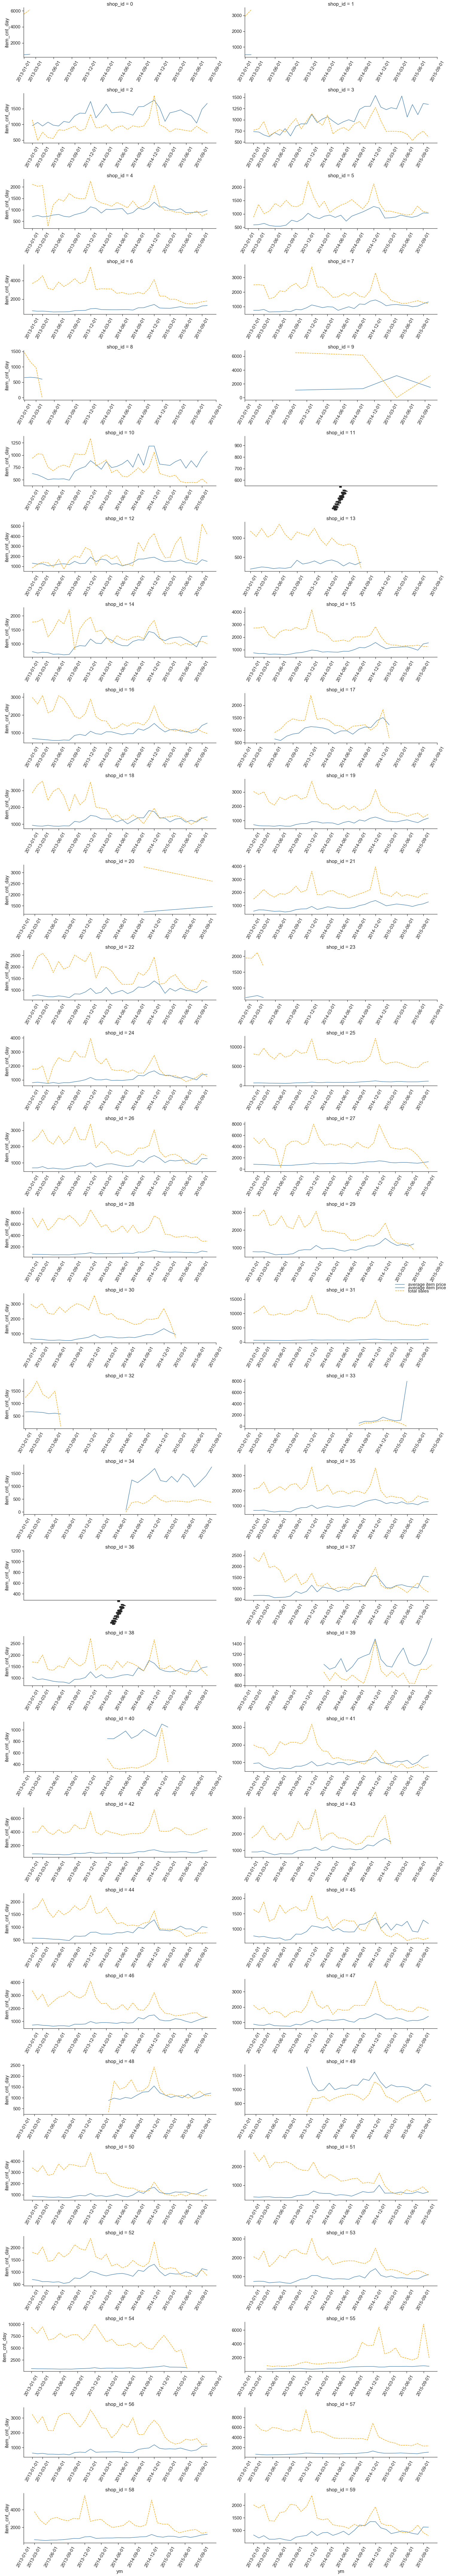

In [27]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

sns.set(style="ticks", color_codes=True, font_scale=1.4)
g = sns.FacetGrid(monthly_prices_sales_per_shop, col='shop_id', col_wrap=2, 
                  height=4, aspect = 2, dropna=False, sharex = False, sharey = False)
g = g.map(plt.plot, 'ym', 'item_price',color = 'steelblue',
          linestyle = '-',
          label = 'average item price').add_legend().set(xticks=ticks)
g = g.map(plt.plot, 'ym', 'item_cnt_day', color = 'orange',
          linestyle = '--', label = 'total sales').add_legend().set(xticks=ticks)
g = g.set_xticklabels(ticks, rotation=60)
g.fig.tight_layout()

In [28]:
monthly_prices_sales_per_category = sales[['item_price','item_cnt_day',
                              'year', 'month', 'item_category_id']].groupby(['year', 'month',
                                                          'item_category_id']).agg({'item_cnt_day':'sum', 
                         'item_price':'mean'}).reset_index()


In [29]:
monthly_prices_sales_per_category['ym'] = pd.to_datetime(['{}-{}-01'.format(y, m) for y,
                m in zip(monthly_prices_sales_per_category.year, monthly_prices_sales_per_category.month)])

In [30]:
monthly_prices_sales_per_category['ym'] = monthly_prices_sales_per_category['ym'].apply( lambda x: x.date())
ticks = list(set([x for x in monthly_prices_sales_per_category['ym'] if str(x) in ['2013-01-01','2013-03-01',
                                                                 '2013-06-01', '2013-09-01', '2013-12-01',
                                                                 '2014-03-01',
                                                                 '2014-06-01', '2014-09-01', '2014-12-01',
                                                                  '2015-03-01',            
                                                                 '2015-06-01', '2015-09-01']]))

Text(0.5, 0.98, 'Item Categories Sales and Prices')

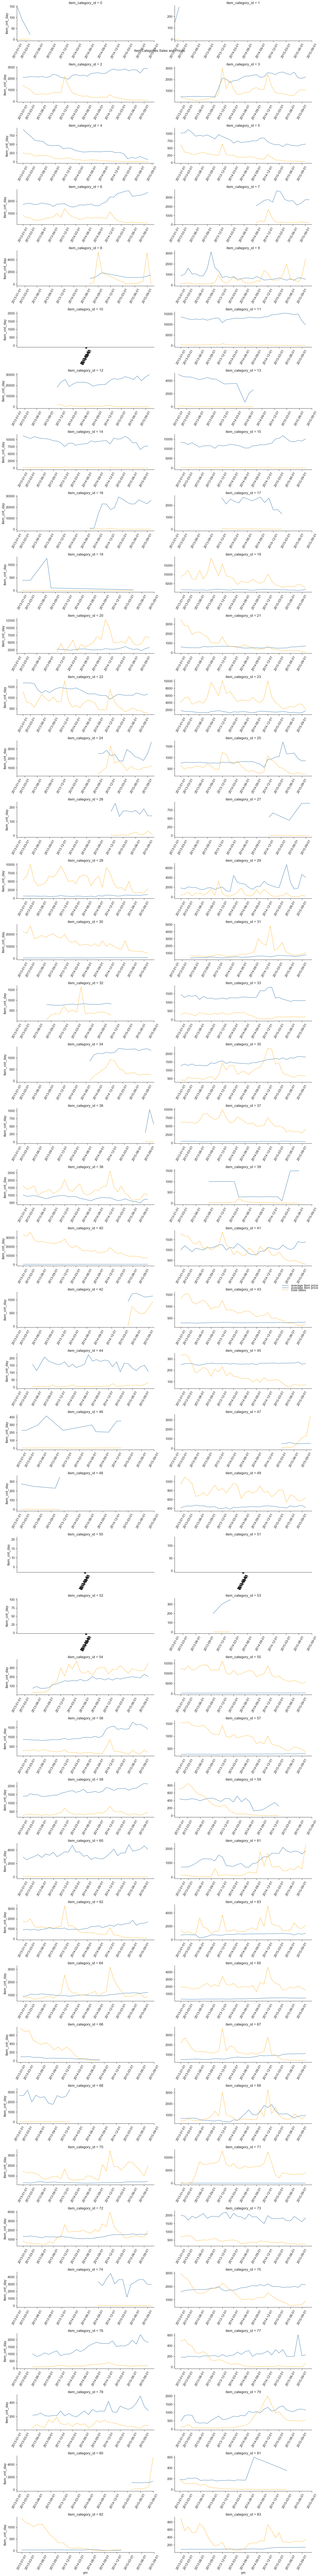

In [31]:
sns.set(style="ticks", color_codes=True, font_scale=1.4)
g = sns.FacetGrid(monthly_prices_sales_per_category, col='item_category_id', col_wrap=2, height=4, aspect = 2,
                  dropna=False, sharex = False, sharey = False)
g = g.map(plt.plot, 'ym', 'item_price',color = 'steelblue',
          linestyle = '-', label = 'average item price').add_legend().set(xticks=ticks)
g = g.map(plt.plot, 'ym', 'item_cnt_day', color = 'orange',
          linestyle = '--', label = 'total sales').add_legend().set(xticks=ticks)

g = g.set_xticklabels(ticks, rotation=60)
g.fig.tight_layout()
g.fig.suptitle('Item Categories Sales and Prices', fontsize = 16)

In [32]:
#Check if the same item is sold with different price at the same time
arbitrage = pd.DataFrame(sales[['date', 'item_price', 'item_name']].groupby(['date', 'item_price',
                                                                'item_name']).size().sort_index()).reset_index()

In [33]:
arbitrage.head()

date  item_price                                          item_name  0
0 2013-01-01         9.0         Крафт пакет "Интересные подарки"-оранжевый  1
1 2013-01-01        10.0         Крафт пакет "Интересные подарки"-оранжевый  1
2 2013-01-01        13.0  Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...  1
3 2013-01-01        14.0       Компактдиск Mirex DVD-R 4,7 Гб 16x Slim case  1
4 2013-01-01        20.0           ZL003 Лазерные наклейки Смайлики большие  2

In [34]:
arbitrage_check = pd.DataFrame(arbitrage[['date', 'item_name', 'item_price']].groupby(['date', 'item_name']).size())

In [35]:
arbitrage_check = arbitrage_check[arbitrage_check.loc[:,0] > 1].reset_index()

In [36]:
arbitrage_check.head()

date                                  item_name  0
0 2013-01-01                                        1+1  2
1 2013-01-01  100 шедевров классики (mp3-CD) (Digipack)  2
2 2013-01-01                     1812: УЛАНСКАЯ БАЛЛАДА  2
3 2013-01-01               3D Crystal Puzzle Дельфин XL  2
4 2013-01-01   Assassin's Creed 3 [PS3, русская версия]  2

In [37]:
#seems like there is arbitrage!
sales[(sales['item_name'] == "100 шедевров классики (mp3-CD) (Digipack)") & (sales['date'] == '2013-01-01 00:00:00')]

date  date_block_num  shop_id  item_id  item_price  \
844094  2013-01-01               0       54       59       249.0   
1273969 2013-01-01               0       51       59       110.0   

         item_cnt_day                                  item_name  \
844094            1.0  100 шедевров классики (mp3-CD) (Digipack)   
1273969           1.0  100 шедевров классики (mp3-CD) (Digipack)   

         item_category_id item_category_name                  shop_name  \
844094                 57       Музыка - MP3            Химки ТЦ "Мега"   
1273969                57       Музыка - MP3  Тюмень ТЦ "Зеленый Берег"   

         month  day  year  weekday  is_holiday  days_to_next_holiday  
844094       1    1  2013        1         1.0                     0  
1273969      1    1  2013        1         1.0                     0

In [38]:
expensive = pd.DataFrame(arbitrage[['date', 'item_name', 'item_price']].groupby(['date', 'item_name']).max()).reset_index()

In [39]:
expensive[(expensive['item_name'] == "ТЕРМИНАТОР ГЕНЕЗИС (BD)") & (expensive['date'] == '2015-10-31 00:00:00')]
expensive = expensive.merge(arbitrage_check.iloc[:,:-1], how = 'inner', on = ['item_name', 'date'])
expensive['is_expensive'] = 1

In [40]:
expensive.head()

date                                  item_name  item_price  \
0 2013-01-01                                        1+1       349.0   
1 2013-01-01  100 шедевров классики (mp3-CD) (Digipack)       249.0   
2 2013-01-01                     1812: УЛАНСКАЯ БАЛЛАДА       399.0   
3 2013-01-01               3D Crystal Puzzle Дельфин XL       399.0   
4 2013-01-01   Assassin's Creed 3 [PS3, русская версия]      2599.0   

   is_expensive  
0             1  
1             1  
2             1  
3             1  
4             1

In [41]:
sales = sales.merge(right = expensive , how = 'left' , right_on = ['item_name','date', 'item_price'] , left_on = ['item_name','date', 'item_price'], copy = False)

In [42]:
sales['is_expensive'] = sales['is_expensive'].fillna(0)

In [43]:
sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154       999.0           1.0   
1 2013-05-16               4       59     2573       249.0           1.0   
2 2013-01-26               0       59     2574       399.0           1.0   
3 2013-01-09               0       59     2574       399.0           1.0   
4 2013-02-24               1       59     2574       399.0           1.0   

                                           item_name  item_category_id  \
0                                  ЯВЛЕНИЕ 2012 (BD)                37   
1                          DEL REY LANA  Born To Die                55   
2  DEL REY LANA  Born To Die  The Paradise Editio...                55   
3  DEL REY LANA  Born To Die  The Paradise Editio...                55   
4  DEL REY LANA  Born To Die  The Paradise Editio...                55   

                    item_category_name               shop_name  month  day  \
0                       Кино - Blu-Ray  Ярославль ТЦ "Альтаир"      1    2   
1  Музыка - CD локального производства  Ярославль ТЦ "Альтаир"      5   16   
2  Музыка - CD локального производства  Ярославль ТЦ "Альтаир"      1   26   
3  Музыка - CD локального производства  Ярославль ТЦ "Альтаир"      1    9   
4  Музыка - CD локального производства  Ярославль ТЦ "Альтаир"      2   24   

   year  weekday  is_holiday  days_to_next_holiday  is_expensive  
0  2013        2         1.0                     0           0.0  
1  2013        3         0.0                    27           0.0  
2  2013        5         0.0                    28           0.0  
3  2013        2         0.0                    45           1.0  
4  2013        6         0.0                    12           0.0

C:\Users\mo63he\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\mo63he\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\mo63he\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\mo63he\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Text(0.5, 0.98, 'Item Prices')

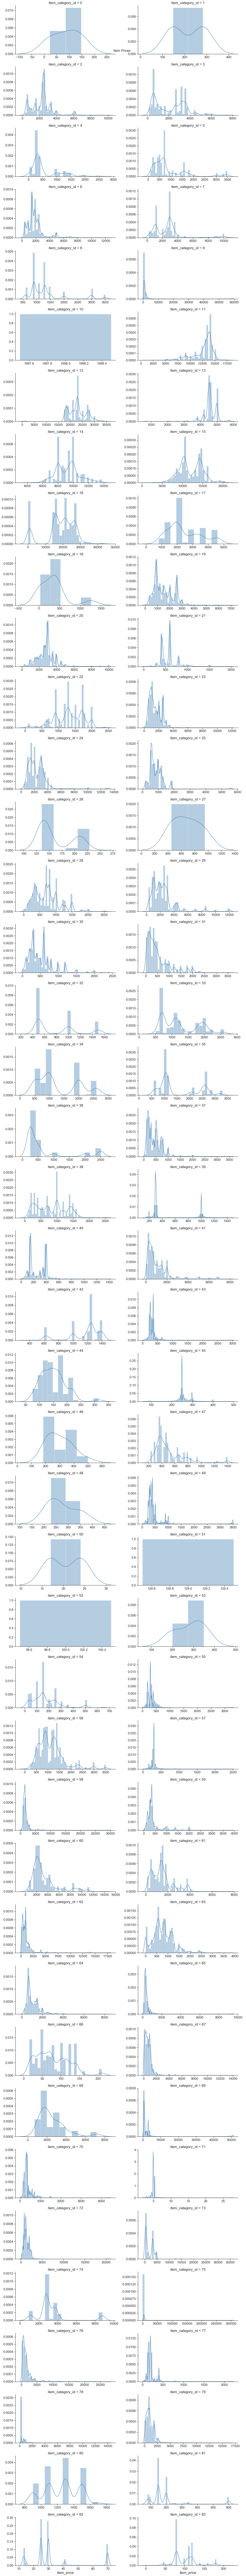

In [44]:
sns.set(style="ticks", color_codes=True, font_scale=1.4)
g = sns.FacetGrid(sales, col='item_category_id', col_wrap=2, height=4, aspect = 2,
                  dropna=False, sharex = False, sharey = False)
g = g.map(sns.distplot, 'item_price',color = 'steelblue').add_legend()
g.fig.tight_layout()
g.fig.suptitle('Item Prices', fontsize = 16)

Text(0.5, 0.98, 'Item Prices')

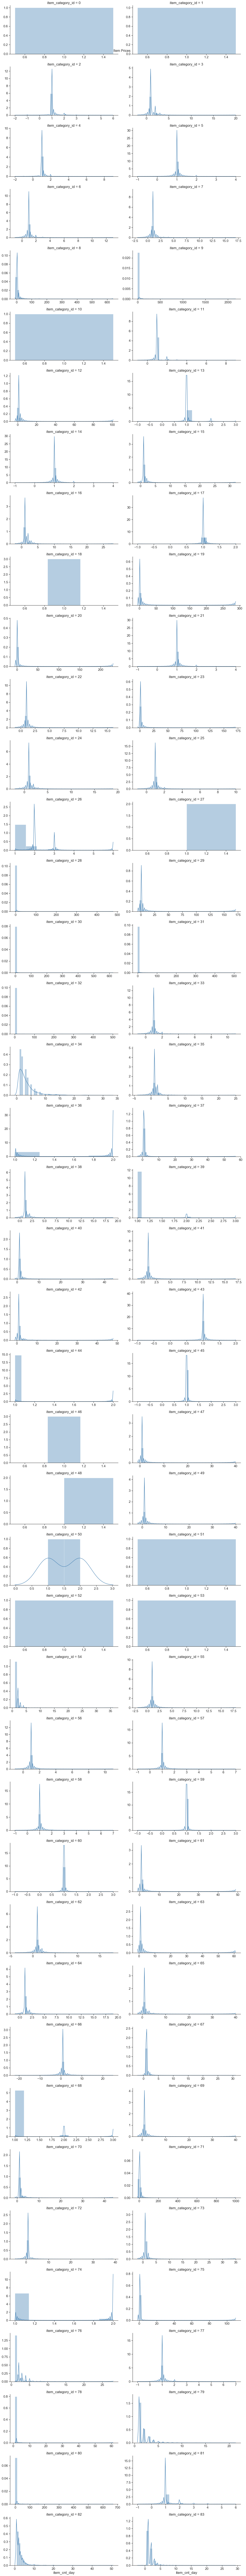

In [45]:
sns.set(style="ticks", color_codes=True, font_scale=1.4)
g = sns.FacetGrid(sales, col='item_category_id', col_wrap=2, height=4, aspect = 2,
                  dropna=False, sharex = False, sharey = False)
g = g.map(sns.distplot, 'item_cnt_day',color = 'steelblue').add_legend()
g.fig.tight_layout()
g.fig.suptitle('Item Prices', fontsize = 16)

In [46]:
category_salesper_weekday = sales[['weekday', 'item_cnt_day','item_category_id']].groupby(['weekday','item_category_id']).sum().reset_index()

C:\Users\mo63he\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 0.98, 'Item Prices')

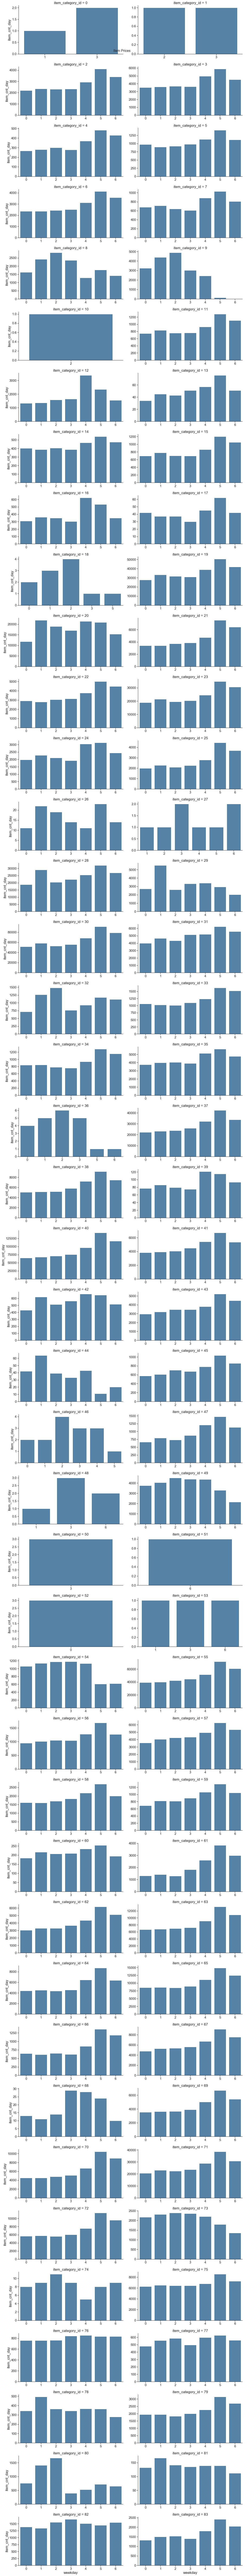

In [47]:
sns.set(style="ticks", color_codes=True, font_scale=1.4)
g = sns.FacetGrid(category_salesper_weekday, col='item_category_id', col_wrap=2, height=4, aspect = 2,
                  dropna=False, sharex = False, sharey = False)
g = g.map(sns.barplot, 'weekday', 'item_cnt_day',color = 'steelblue').add_legend()
g.fig.tight_layout()
g.fig.suptitle('Item Prices', fontsize = 16)

In [48]:
max_prices = sales[['item_id','shop_id','item_price']].groupby(['item_id','shop_id']).max().reset_index()
max_prices = max_prices.rename(columns = {'item_price': 'item_max_price'})

In [49]:
sales = sales.merge(max_prices)

In [50]:
sales['price_to_max_price_ratio'] = sales['item_price'] / sales['item_max_price']

In [51]:
avg_sales_lm1 = sales[['shop_id',
       'item_id',
        'item_cnt_day',
        'date']].set_index('date').groupby(['shop_id',
                                                      'item_id'])['item_cnt_day'].rolling('30D').mean().reset_index()

In [52]:
avg_sales_lm1 = avg_sales_lm1.rename(columns = {'item_cnt_day' : 'avg_sales_lm1'})

In [53]:
sales.shape

(2935849, 19)

In [54]:
sales = sales.merge(avg_sales_lm1)

In [55]:
sales = sales.drop_duplicates()

In [56]:
sales[(sales.item_id == 11373) & (sales.shop_id == 12)].groupby(['date_block_num', 'item_name']).agg({'item_cnt_day':'sum', 
                         'item_price':'mean'})
#seems like this a data leakage see last month

item_cnt_day  item_price
date_block_num item_name                                                     
0              Доставка до пункта выдачи (Boxberry)           6.0  548.900000
1              Доставка до пункта выдачи (Boxberry)           2.0  179.500000
2              Доставка до пункта выдачи (Boxberry)          21.0  195.333333
3              Доставка до пункта выдачи (Boxberry)           9.0  192.733333
4              Доставка до пункта выдачи (Boxberry)           7.0  382.000000
5              Доставка до пункта выдачи (Boxberry)          28.0  258.783333
6              Доставка до пункта выдачи (Boxberry)           9.0  374.937500
7              Доставка до пункта выдачи (Boxberry)          39.0  355.737500
8              Доставка до пункта выдачи (Boxberry)          33.0  645.531250
9              Доставка до пункта выдачи (Boxberry)          51.0  555.993506
10             Доставка до пункта выдачи (Boxberry)         373.0  557.701412
11             Доставка до пункта выдачи (Boxberry)          77.0  242.514365
12             Доставка до пункта выдачи (Boxberry)          46.0  287.859127
13             Доставка до пункта выдачи (Boxberry)         183.0  245.458975
14             Доставка до пункта выдачи (Boxberry)         203.0  278.013951
15             Доставка до пункта выдачи (Boxberry)          61.0  469.822906
16             Доставка до пункта выдачи (Boxberry)         147.0  360.084014
17             Доставка до пункта выдачи (Boxberry)          50.0  325.731349
18             Доставка до пункта выдачи (Boxberry)          32.0  530.547619
19             Доставка до пункта выдачи (Boxberry)          39.0  333.871795
20             Доставка до пункта выдачи (Boxberry)          98.0  398.154147
21             Доставка до пункта выдачи (Boxberry)          68.0  386.014815
22             Доставка до пункта выдачи (Boxberry)         308.0  326.641027
23             Доставка до пункта выдачи (Boxberry)         265.0  290.467873
24             Доставка до пункта выдачи (Boxberry)         133.0  239.000086
25             Доставка до пункта выдачи (Boxberry)         117.0  302.767273
26             Доставка до пункта выдачи (Boxberry)         147.0  398.995625
27             Доставка до пункта выдачи (Boxberry)         292.0  362.779133
28             Доставка до пункта выдачи (Boxberry)         742.0  329.588106
29             Доставка до пункта выдачи (Boxberry)         202.0  254.446254
30             Доставка до пункта выдачи (Boxberry)         201.0  289.829260
31             Доставка до пункта выдачи (Boxberry)          75.0  504.177438
32             Доставка до пункта выдачи (Boxberry)         246.0  437.929115
33             Доставка до пункта выдачи (Boxberry)        2253.0  382.224936

In [57]:
sales[(sales.item_id == 9248) & (sales.shop_id == 12)].groupby(['date_block_num']).agg({'item_cnt_day':'sum', 
                         'item_price':'mean'})
#and again

item_cnt_day   item_price
date_block_num                           
27                      13.0  1300.000000
28                      11.0  1300.000000
29                       3.0  1300.000000
30                      12.0  1300.000000
31                      19.0  1342.857143
32                    1644.0  1508.318762

In [58]:
sales[(sales.item_id == 9249) & (sales.shop_id == 55)].groupby(['date_block_num', 'item_category_name']).agg({'item_cnt_day':'sum', 
                         'item_price':'mean'})
#and again

item_cnt_day   item_price
date_block_num item_category_name                           
27             Билеты (Цифра)              13.0  1300.000000
28             Билеты (Цифра)              13.0  1300.000000
29             Билеты (Цифра)               3.0  1300.000000
30             Билеты (Цифра)              12.0  1300.000000
31             Билеты (Цифра)              19.0  1342.857143
32             Билеты (Цифра)            1644.0  1506.993991

In [59]:
sales[(sales.item_id == 19437) & (sales.shop_id == 55)].groupby(['date_block_num', 'item_category_name']).agg({'item_cnt_day':'sum', 
                         'item_price':'mean'})
#and again

item_cnt_day  item_price
date_block_num item_category_name                          
21             Игры PC - Цифра           1074.0       899.0
22             Игры PC - Цифра              3.0       800.0
23             Игры PC - Цифра              3.0       899.0
24             Игры PC - Цифра            279.0       708.0
25             Игры PC - Цифра              1.0       899.0
26             Игры PC - Цифра              1.0       899.0
27             Игры PC - Цифра              1.0       899.0

In [559]:
del max_prices

In [78]:
sales.shape

Index(['item_category_id', 'tsvd_0', 'tsvd_1', 'tsvd_2', 'tsvd_3', 'tsvd_4',
       'tsvd_5', 'tsvd_6', 'tsvd_7', 'tsvd_8', 'tsvd_9'],
      dtype='object')

In [24]:
sales = sales.merge(cat_id_tfidf, how = 'left')

In [25]:
cat_tfidf = sales[['item_id', 'tsvd_0', 'tsvd_1', 'tsvd_2', 'tsvd_3', 'tsvd_4', 'tsvd_5',
       'tsvd_6', 'tsvd_7', 'tsvd_8', 'tsvd_9']].drop_duplicates()

In [26]:
sales_train = sales.groupby(['date_block_num', 'item_id','shop_id','year','month']).agg({'item_cnt_day':'sum', 
                         'item_price':'mean'}).reset_index()

In [27]:
sales_train.head()

date_block_num  item_id  shop_id  year  month  item_cnt_day  item_price
0               0       19       25  2013      1           1.0        28.0
1               0       27        1  2013      1           1.0      1890.0
2               0       27        2  2013      1           1.0      2499.0
3               0       27       10  2013      1           1.0      1890.0
4               0       27       19  2013      1           1.0      2499.0

In [28]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':[np.mean, np.max, np.median, np.min, np.std, np.sum] ,
                                                        'item_price':[np.mean, np.max, np.median, np.min, np.std]})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [29]:
all_data.columns = ['shop_id', 'item_id', 'date_block_num',
       'item_cnt_day mean', 'item_cnt_day amax',
       'item_cnt_day median', 'item_cnt_day amin', 'item_cnt_day std', 'item_cnt_day sum',
       'item_price mean', 'item_price amax',
        'item_price median', 'item_price amin', 'item_price std']

In [30]:
sales_train = all_data.merge(sales_train[['date_block_num', 'year', 'month']].drop_duplicates())

In [31]:
sales_train['month_next_1'] = sales_train['date_block_num'] - 1
sales_train['month_last_1'] = sales_train['date_block_num'] + 1
sales_train['month_last_2'] = sales_train['date_block_num'] + 2
sales_train['month_last_3'] = sales_train['date_block_num'] + 3
sales_train['month_last_4'] = sales_train['date_block_num'] + 4
sales_train['month_last_5'] = sales_train['date_block_num'] + 5
sales_train['month_last_6'] = sales_train['date_block_num'] + 6

sales_train['month_last_9'] = sales_train['date_block_num'] + 9
sales_train['month_last_12'] = sales_train['date_block_num'] + 12

In [32]:
sales_cur = sales_train[['shop_id', 'item_id', 'date_block_num', 'item_cnt_day mean',
       'item_cnt_day amax', 'item_cnt_day median', 'item_cnt_day amin',
       'item_cnt_day std', 'item_cnt_day sum', 'item_price mean',
       'item_price amax', 'item_price median', 'item_price amin',
       'item_price std', 'year', 'month']].copy()

In [33]:
#sales_cur['item_cnt_day sum'] = sales_cur['item_cnt_day sum'].clip(0, 20)

In [34]:
cols1 = ['item_cnt_day sum','item_cnt_lm_1', 'item_cnt_lm_2', 'item_cnt_lm_3','item_cnt_lm_4',
         'item_cnt_lm_5', 'item_cnt_lm_6', 'item_cnt_lm_9', 'item_cnt_lm_12']
cols2 = ['item_cnt_lm_1', 'item_cnt_lm_2', 'item_cnt_lm_3','item_cnt_lm_4',
         'item_cnt_lm_5', 'item_cnt_lm_6', 'item_cnt_lm_9', 'item_cnt_lm_12','item_cnt_next_1']
periods = ['month_last_1', 'month_last_2','month_last_3',
           'month_last_4','month_last_5','month_last_6', 'month_last_9', 'month_last_12', 'month_next_1']
for c1, c2, period in zip(cols1,cols2, periods):
    sales_train = sales_train.rename(columns = {c1: c2})
    sales_cur = sales_cur.merge(sales_train[[period, 'item_id', 'shop_id',c2]], how = 'left',
                                left_on = ['date_block_num', 'item_id','shop_id'],
                           right_on = [period, 'item_id','shop_id'])

In [35]:
holiday_per_month_df = pd.DataFrame.from_dict(holiday_per_month , orient='index').reset_index()

In [36]:
holiday_per_month_df.columns = ['month','nr_of_holidays']

In [37]:
sales_cur = sales_cur[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day mean',
       'item_cnt_day amax', 'item_cnt_day median', 'item_cnt_day amin',
       'item_cnt_day std', 'item_cnt_day sum', 'item_price mean',
       'item_price amax', 'item_price median', 'item_price amin',
       'item_price std', 'year', 'month', 'item_cnt_lm_1',
        'item_cnt_lm_2','item_cnt_lm_3',
        'item_cnt_lm_4',  'item_cnt_lm_5',
        'item_cnt_lm_6', 'item_cnt_lm_9',
      'item_cnt_lm_12', 'month_next_1', 'item_cnt_next_1']]

In [38]:
sales_cur = sales_cur.fillna(0)

In [39]:
sales_cur['diff_lm_1'] = sales_cur['item_cnt_day sum'] - sales_cur['item_cnt_lm_1']
sales_cur['diff_lm_2'] = sales_cur['item_cnt_lm_1'] - sales_cur['item_cnt_lm_2']
sales_cur['diff_lm_3'] = sales_cur['item_cnt_lm_2'] - sales_cur['item_cnt_lm_3']
sales_cur['diff_lm_4'] = sales_cur['item_cnt_lm_3'] - sales_cur['item_cnt_lm_4']
sales_cur['diff_lm_5'] = sales_cur['item_cnt_lm_5'] - sales_cur['item_cnt_lm_6']

sales_cur['diff_lm_3_6'] = sales_cur['item_cnt_lm_3'] - sales_cur['item_cnt_lm_6']
sales_cur['diff_lm_2_6'] = sales_cur['item_cnt_lm_2'] - sales_cur['item_cnt_lm_6']
sales_cur['diff_lm_1_6'] = sales_cur['item_cnt_lm_1'] - sales_cur['item_cnt_lm_6']
sales_cur['diff_lm_6_9'] = sales_cur['item_cnt_lm_6'] - sales_cur['item_cnt_lm_9']
sales_cur['diff_lm_9_12'] = sales_cur['item_cnt_lm_9'] - sales_cur['item_cnt_lm_12']
sales_cur['diff_lm_1_9'] = sales_cur['item_cnt_lm_1'] - sales_cur['item_cnt_lm_9']
sales_cur['diff_lm_1_12'] = sales_cur['item_cnt_lm_1'] - sales_cur['item_cnt_lm_12']
sales_cur['diff_lm_3_9'] = sales_cur['item_cnt_lm_3'] - sales_cur['item_cnt_lm_9']
sales_cur['diff_lm_3_12'] = sales_cur['item_cnt_lm_3'] - sales_cur['item_cnt_lm_12']
sales_cur['diff_lm_6_12'] = sales_cur['item_cnt_lm_6'] - sales_cur['item_cnt_lm_12']
sales_cur['diff2_lm'] = sales_cur['diff_lm_1'] - sales_cur['diff_lm_2']
sales_cur['diff2_lm2'] = sales_cur['diff_lm_2'] - sales_cur['diff_lm_3']

In [40]:
sales_cur = sales_cur.merge(holiday_per_month_df , how = 'left')

In [41]:
sales_cur.head()

date_block_num  shop_id  item_id  item_cnt_day mean  item_cnt_day amax  \
0               0        0       19                0.0                0.0   
1               0        0       27                0.0                0.0   
2               0        0       28                0.0                0.0   
3               0        0       29                0.0                0.0   
4               0        0       32                1.5                2.0   

   item_cnt_day median  item_cnt_day amin  item_cnt_day std  item_cnt_day sum  \
0                  0.0                0.0           0.00000               0.0   
1                  0.0                0.0           0.00000               0.0   
2                  0.0                0.0           0.00000               0.0   
3                  0.0                0.0           0.00000               0.0   
4                  1.5                1.0           0.57735               6.0   

   item_price mean  ...  diff_lm_6_9  diff_lm_9_12  diff_lm_1_9  diff_lm_1_12  \
0              0.0  ...          0.0           0.0          0.0           0.0   
1              0.0  ...          0.0           0.0          0.0           0.0   
2              0.0  ...          0.0           0.0          0.0           0.0   
3              0.0  ...          0.0           0.0          0.0           0.0   
4            221.0  ...          0.0           0.0          0.0           0.0   

   diff_lm_3_9  diff_lm_3_12  diff_lm_6_12  diff2_lm  diff2_lm2  \
0          0.0           0.0           0.0       0.0        0.0   
1          0.0           0.0           0.0       0.0        0.0   
2          0.0           0.0           0.0       0.0        0.0   
3          0.0           0.0           0.0       0.0        0.0   
4          0.0           0.0           0.0       6.0        0.0   

   nr_of_holidays  
0             8.0  
1             8.0  
2             8.0  
3             8.0  
4             8.0  

[5 rows x 44 columns]

In [42]:
del sales_train

sales_cur['day'] = 1
sales_cur['start'] = pd.to_datetime(sales_cur[['year', 'month', 'day']])

In [43]:
import datetime, calendar
def weekday_count(start):
    start_date  = start + pd.to_timedelta(1,unit='M')
    end_date    = start_date + pd.to_timedelta(1,unit='M')
    if end_date.month != start_date.month:
        end_date = end_date - pd.to_timedelta(1,unit='d')
    week        = {}
    for i in range((end_date - start_date).days):
        day       = calendar.day_name[(start_date + datetime.timedelta(days=i+1)).weekday()]
        week[day] = week[day] + 1 if day in week else 1
    week['start'] = start
    wk = pd.DataFrame(week , index=[0])
    return wk

In [44]:
wk_df = pd.DataFrame()
for start in sorted(set(sales_cur['start'])):
    wk_df = wk_df.append(weekday_count(start), ignore_index=False)

C:\Users\mo63he\anaconda3\lib\site-packages\pandas\util\_decorators.py:208: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  return func(*args, **kwargs)
C:\Users\mo63he\anaconda3\lib\site-packages\pandas\core\tools\timedeltas.py:134: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  result = Timedelta(r, unit)
C:\Users\mo63he\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [45]:
sales_cur = sales_cur.merge(wk_df)
del wk_df

In [46]:
first_to_market_df = sales_cur.groupby('item_id')['date_block_num'].min().reset_index()
first_to_market_df = first_to_market_df.rename(columns = {'date_block_num':'time_in_market'})
sales_cur = sales_cur.merge(first_to_market_df, how = 'left')
sales_cur['time_in_market'] = sales_cur['date_block_num'] - sales_cur['time_in_market']

In [47]:
sales_cur = sales_cur[['date_block_num', 'item_id', 'shop_id', 'year', 'month',
       'item_cnt_day sum', 'item_cnt_day mean', 'item_cnt_day amax',
       'item_cnt_day median', 'item_cnt_day amin', 'item_cnt_day std',
       'item_cnt_lm_1', 'item_cnt_lm_2', 'item_price mean', 'item_price amax',
       'item_cnt_lm_6', 'item_price median', 'item_price amin',
       'item_cnt_lm_4', 'item_cnt_lm_5', 'item_cnt_lm_9', 'item_cnt_lm_12',
       'item_cnt_lm_3', 'diff_lm_1', 'diff_lm_2',
       'diff_lm_3', 'diff_lm_4', 'diff_lm_5', 'diff_lm_3_6', 'diff_lm_2_6',
       'diff_lm_1_6', 'diff_lm_6_9', 'diff_lm_9_12', 'diff_lm_1_9','Monday',
                       'Tuesday','Wednesday','Thursday','Friday','Saturday',
                       'Sunday','time_in_market',
       'diff_lm_1_12', 'diff_lm_3_9', 'diff_lm_3_12', 'diff_lm_6_12',
       'diff2_lm', 'diff2_lm2', 'nr_of_holidays', 'item_cnt_next_1']]

In [48]:
train = sales_cur[sales_cur.date_block_num < 33]
val = sales_cur[sales_cur.date_block_num == 33]
oo_scope_shops = list(set(sales_cur.shop_id.unique()).difference(set(val['shop_id'].unique())))
oo_scope_items = list(set(sales_cur.item_id.unique()).difference(set(val['item_id'].unique())))
del sales_cur
train = train[~(train.item_id.isin(oo_scope_items) & train.shop_id.isin(oo_scope_shops))]
val = val[~(val.item_id.isin(oo_scope_items) & val.shop_id.isin(oo_scope_shops))]

In [49]:
del all_data
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

C:\Users\mo63he\anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


### Mean Encodings

In [50]:
print(all_data.shape)
all_data = all_data.merge(sales[['shop_id','item_id', 'date_block_num', 'item_category_id']], how = 'left').drop_duplicates()

(10913850, 4)


In [51]:
mean_item = all_data.groupby('item_id')['target'].mean()
count_item = all_data.groupby('item_id')['target'].count()
all_data['target_mean_item'] = all_data['item_id'].map(mean_item)
all_data['target_count_item'] = all_data['item_id'].map(count_item)

mean_cat = all_data.groupby('item_category_id')['target'].mean()
count_cat = all_data.groupby('item_category_id')['target'].count()

all_data['target_mean_cat'] = all_data['item_category_id'].map(mean_cat)
all_data['target_count_cat'] = all_data['item_category_id'].map(count_cat)

mean_shop = all_data.groupby('shop_id')['target'].mean()
count_shop = all_data.groupby('shop_id')['target'].count()
all_data['target_mean_shop'] = all_data['shop_id'].map(mean_shop)
all_data['target_count_shop'] = all_data['shop_id'].map(count_shop)
all_data['target_mean_enc_per_shop'] = (all_data['target_mean_shop'] * all_data['target_count_shop'] + 100*mean_shop.mean()) / (all_data['target_count_shop'] + 100)
all_data['target_mean_enc_per_item'] = (all_data['target_mean_item'] * all_data['target_count_item'] + 100*0.3343) / (all_data['target_count_item'] + 100)
all_data['target_mean_enc_per_cat'] = (all_data['target_mean_cat'] * all_data['target_count_cat'] + 1000*mean_cat.mean()) / (all_data['target_count_cat'] + 1000)


In [52]:
train = train.merge(all_data[['date_block_num', 'shop_id', 'item_id','target_mean_enc_per_item', 'target_mean_enc_per_shop',
                              'target_mean_enc_per_cat']], how = 'inner')

In [53]:
val = val.merge(all_data[['date_block_num', 'shop_id', 'item_id','target_mean_enc_per_item', 'target_mean_enc_per_shop',
                         'target_mean_enc_per_cat']])

In [54]:
cats = train.groupby(['item_id'])['target_mean_enc_per_cat'].mean().reset_index()

In [55]:
cats['target_mean_enc_per_cat'] = cats['target_mean_enc_per_cat'].fillna(cats['target_mean_enc_per_cat'].mean())

In [56]:
cats = cats.rename(columns={'target_mean_enc_per_cat':'means'})

In [57]:
train = train.merge(cats, how = 'left')
val = val.merge(cats, how= 'left')

In [58]:
train.columns

Index(['date_block_num', 'item_id', 'shop_id', 'year', 'month',
       'item_cnt_day sum', 'item_cnt_day mean', 'item_cnt_day amax',
       'item_cnt_day median', 'item_cnt_day amin', 'item_cnt_day std',
       'item_cnt_lm_1', 'item_cnt_lm_2', 'item_price mean', 'item_price amax',
       'item_cnt_lm_6', 'item_price median', 'item_price amin',
       'item_cnt_lm_4', 'item_cnt_lm_5', 'item_cnt_lm_9', 'item_cnt_lm_12',
       'item_cnt_lm_3', 'diff_lm_1', 'diff_lm_2', 'diff_lm_3', 'diff_lm_4',
       'diff_lm_5', 'diff_lm_3_6', 'diff_lm_2_6', 'diff_lm_1_6', 'diff_lm_6_9',
       'diff_lm_9_12', 'diff_lm_1_9', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'time_in_market',
       'diff_lm_1_12', 'diff_lm_3_9', 'diff_lm_3_12', 'diff_lm_6_12',
       'diff2_lm', 'diff2_lm2', 'nr_of_holidays', 'item_cnt_next_1',
       'target_mean_enc_per_item', 'target_mean_enc_per_shop',
       'target_mean_enc_per_cat', 'means'],
      dtype='object')

In [59]:
train['target_mean_enc_per_cat'] = train['target_mean_enc_per_cat'].fillna(train['means'])
val['target_mean_enc_per_cat'] = val['target_mean_enc_per_cat'].fillna(val['means'])

In [60]:
train = train.merge(cat_tfidf, how = 'left')
val = val.merge(cat_tfidf, how = 'left')

In [62]:
shops['shop_city'] = shops['shop_name'].apply(lambda x: x.split()[0])
sales = sales.merge(shops[['shop_id','shop_city']])
train = train.merge(shops[['shop_id','shop_city']])
val = val.merge(shops[['shop_id','shop_city']])

In [65]:
shop_city_avg = train.groupby('shop_city')['item_cnt_next_1'].mean().reset_index()
shop_city_avg = shop_city_avg.rename(columns = {'item_cnt_next_1':'target_mean_per_shop_city'})
train = train.merge(shop_city_avg)
val = val.merge(shop_city_avg)

In [66]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train['shop_city'] = encoder.fit_transform(train['shop_city'])
val['shop_city'] = encoder.transform(val['shop_city'])
train['item_cnt_next_1'] = train['item_cnt_next_1'].clip(0, 20)
val['item_cnt_next_1'] = val['item_cnt_next_1'].clip(0, 20)


In [67]:
del all_data
all_data = train.append(val)

In [68]:
item_cnt_per_item = sales.groupby(['item_id','date_block_num']).agg({'item_cnt_day':{'item_cnt_avg_per_item': 'mean',
                                                'item_cnt_asum_per_item': 'sum'}}).reset_index()
item_cnt_per_item.columns = ['item_id','date_block_num', 'item_cnt_avg_per_item', 'item_cnt_asum_per_item']

item_cnt_per_shop = sales.groupby(['shop_id','date_block_num']).agg({'item_cnt_day':{'item_cnt_avg_per_shop': 'mean',
                                                'item_cnt_asum_per_shop': 'sum'}}).reset_index()
item_cnt_per_shop.columns = ['shop_id','date_block_num', 'item_cnt_avg_per_shop', 'item_cnt_asum_per_shop']

item_cnt_per_city = sales.groupby(['shop_city','date_block_num']).agg({'item_cnt_day':{'item_cnt_avg_per_city': 'mean',
                                                'item_cnt_asum_per_city': 'sum'}}).reset_index()
item_cnt_per_city.columns = ['shop_city','date_block_num', 'item_cnt_avg_per_city', 'item_cnt_asum_per_city']
item_cnt_per_city['shop_city'] = encoder.transform(item_cnt_per_city['shop_city'])
del sales

In [76]:
del train
del val
all_data = all_data.merge(item_cnt_per_item)
all_data = all_data.merge(item_cnt_per_shop)
all_data = all_data.merge(item_cnt_per_city)

In [77]:
from tqdm import tqdm_notebook

In [79]:
index_cols = ['shop_id', 'item_id', 'date_block_num'] 

cols_to_rename = ['item_cnt_avg_per_item', 'item_cnt_asum_per_item',
       'item_cnt_avg_per_shop', 'item_cnt_asum_per_shop',
       'item_cnt_avg_per_city', 'item_cnt_asum_per_city']

shift_range = [1, 2, 3, 6]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

In [82]:
val = all_data[all_data.date_block_num == 33]
val = val[['date_block_num', 'item_id', 'shop_id',
       'item_cnt_day sum', 'item_cnt_day mean', 'item_cnt_day amax',
       'item_cnt_day median', 'item_cnt_day amin', 'item_cnt_day std',
       'item_cnt_lm_1', 'item_cnt_lm_2', 'item_price mean', 'item_price amax',
       'item_cnt_lm_6', 'item_price median', 'item_price amin',
       'item_cnt_lm_4', 'item_cnt_lm_5', 'item_cnt_lm_9', 'item_cnt_lm_12',
       'item_cnt_lm_3', 'diff_lm_1', 'diff_lm_2', 'diff_lm_3', 'diff_lm_4',
       'diff_lm_5', 'diff_lm_3_6', 'diff_lm_2_6', 'diff_lm_1_6', 'diff_lm_6_9',
       'diff_lm_9_12', 'diff_lm_1_9', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'time_in_market',
       'diff_lm_1_12', 'diff_lm_3_9', 'diff_lm_3_12', 'diff_lm_6_12',
       'diff2_lm', 'diff2_lm2', 'nr_of_holidays',
       'target_mean_enc_per_item', 'target_mean_enc_per_shop',
       'target_mean_enc_per_cat', 'means', 'tsvd_0', 'tsvd_1', 'tsvd_2',
       'tsvd_3', 'tsvd_4', 'tsvd_5', 'tsvd_6', 'tsvd_7', 'tsvd_8', 'tsvd_9',
       'shop_city', 'target_mean_per_shop_city', 'item_cnt_avg_per_item',
       'item_cnt_asum_per_item', 'item_cnt_avg_per_shop',
       'item_cnt_asum_per_shop', 'item_cnt_avg_per_city',
       'item_cnt_asum_per_city', 'item_cnt_avg_per_item_lag_1',
       'item_cnt_asum_per_item_lag_1', 'item_cnt_avg_per_shop_lag_1',
       'item_cnt_asum_per_shop_lag_1', 'item_cnt_avg_per_city_lag_1',
       'item_cnt_asum_per_city_lag_1', 'item_cnt_avg_per_item_lag_2',
       'item_cnt_asum_per_item_lag_2', 'item_cnt_avg_per_shop_lag_2',
       'item_cnt_asum_per_shop_lag_2', 'item_cnt_avg_per_city_lag_2',
       'item_cnt_asum_per_city_lag_2', 'item_cnt_avg_per_item_lag_3',
       'item_cnt_asum_per_item_lag_3', 'item_cnt_avg_per_shop_lag_3',
       'item_cnt_asum_per_shop_lag_3', 'item_cnt_avg_per_city_lag_3',
       'item_cnt_asum_per_city_lag_3', 'item_cnt_avg_per_item_lag_6',
       'item_cnt_asum_per_item_lag_6', 'item_cnt_avg_per_shop_lag_6',
       'item_cnt_asum_per_shop_lag_6', 'item_cnt_avg_per_city_lag_6',
       'item_cnt_asum_per_city_lag_6',  'item_cnt_next_1']]

In [85]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse

X_train = all_data[(all_data.date_block_num < 32) & (all_data.date_block_num > 11)]
X_train = X_train[['item_cnt_day sum', 'item_cnt_day mean', 'item_cnt_day amax',
       'item_cnt_day median', 'item_cnt_day amin', 'item_cnt_day std',
       'item_cnt_lm_1', 'item_cnt_lm_2', 'item_price mean', 'item_price amax',
       'item_cnt_lm_6', 'item_price median', 'item_price amin',
       'item_cnt_lm_4', 'item_cnt_lm_5', 'item_cnt_lm_9', 'item_cnt_lm_12',
       'item_cnt_lm_3', 'diff_lm_1', 'diff_lm_2', 'diff_lm_3', 'diff_lm_4',
       'diff_lm_5', 'diff_lm_3_6', 'diff_lm_2_6', 'diff_lm_1_6', 'diff_lm_6_9',
       'diff_lm_9_12', 'diff_lm_1_9', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'time_in_market',
       'diff_lm_1_12', 'diff_lm_3_9', 'diff_lm_3_12', 'diff_lm_6_12',
       'diff2_lm', 'diff2_lm2', 'nr_of_holidays',
       'target_mean_enc_per_item', 'target_mean_enc_per_shop',
       'target_mean_enc_per_cat', 'means', 'tsvd_0', 'tsvd_1', 'tsvd_2',
       'tsvd_3', 'tsvd_4', 'tsvd_5', 'tsvd_6', 'tsvd_7', 'tsvd_8', 'tsvd_9',
       'shop_city', 'target_mean_per_shop_city', 'item_cnt_avg_per_item',
       'item_cnt_asum_per_item', 'item_cnt_avg_per_shop',
       'item_cnt_asum_per_shop', 'item_cnt_avg_per_city',
       'item_cnt_asum_per_city', 'item_cnt_avg_per_item_lag_1',
       'item_cnt_asum_per_item_lag_1', 'item_cnt_avg_per_shop_lag_1',
       'item_cnt_asum_per_shop_lag_1', 'item_cnt_avg_per_city_lag_1',
       'item_cnt_asum_per_city_lag_1', 'item_cnt_avg_per_item_lag_2',
       'item_cnt_asum_per_item_lag_2', 'item_cnt_avg_per_shop_lag_2',
       'item_cnt_asum_per_shop_lag_2', 'item_cnt_avg_per_city_lag_2',
       'item_cnt_asum_per_city_lag_2', 'item_cnt_avg_per_item_lag_3',
       'item_cnt_asum_per_item_lag_3', 'item_cnt_avg_per_shop_lag_3',
       'item_cnt_asum_per_shop_lag_3', 'item_cnt_avg_per_city_lag_3',
       'item_cnt_asum_per_city_lag_3', 'item_cnt_avg_per_item_lag_6',
       'item_cnt_asum_per_item_lag_6', 'item_cnt_avg_per_shop_lag_6',
       'item_cnt_asum_per_shop_lag_6', 'item_cnt_avg_per_city_lag_6',
       'item_cnt_asum_per_city_lag_6']]
X_test = all_data[(all_data.date_block_num == 32)]
X_test = X_test[['item_cnt_day sum', 'item_cnt_day mean', 'item_cnt_day amax',
       'item_cnt_day median', 'item_cnt_day amin', 'item_cnt_day std',
       'item_cnt_lm_1', 'item_cnt_lm_2', 'item_price mean', 'item_price amax',
       'item_cnt_lm_6', 'item_price median', 'item_price amin',
       'item_cnt_lm_4', 'item_cnt_lm_5', 'item_cnt_lm_9', 'item_cnt_lm_12',
       'item_cnt_lm_3', 'diff_lm_1', 'diff_lm_2', 'diff_lm_3', 'diff_lm_4',
       'diff_lm_5', 'diff_lm_3_6', 'diff_lm_2_6', 'diff_lm_1_6', 'diff_lm_6_9',
       'diff_lm_9_12', 'diff_lm_1_9', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'time_in_market',
       'diff_lm_1_12', 'diff_lm_3_9', 'diff_lm_3_12', 'diff_lm_6_12',
       'diff2_lm', 'diff2_lm2', 'nr_of_holidays',
       'target_mean_enc_per_item', 'target_mean_enc_per_shop',
       'target_mean_enc_per_cat', 'means', 'tsvd_0', 'tsvd_1', 'tsvd_2',
       'tsvd_3', 'tsvd_4', 'tsvd_5', 'tsvd_6', 'tsvd_7', 'tsvd_8', 'tsvd_9',
       'shop_city', 'target_mean_per_shop_city', 'item_cnt_avg_per_item',
       'item_cnt_asum_per_item', 'item_cnt_avg_per_shop',
       'item_cnt_asum_per_shop', 'item_cnt_avg_per_city',
       'item_cnt_asum_per_city', 'item_cnt_avg_per_item_lag_1',
       'item_cnt_asum_per_item_lag_1', 'item_cnt_avg_per_shop_lag_1',
       'item_cnt_asum_per_shop_lag_1', 'item_cnt_avg_per_city_lag_1',
       'item_cnt_asum_per_city_lag_1', 'item_cnt_avg_per_item_lag_2',
       'item_cnt_asum_per_item_lag_2', 'item_cnt_avg_per_shop_lag_2',
       'item_cnt_asum_per_shop_lag_2', 'item_cnt_avg_per_city_lag_2',
       'item_cnt_asum_per_city_lag_2', 'item_cnt_avg_per_item_lag_3',
       'item_cnt_asum_per_item_lag_3', 'item_cnt_avg_per_shop_lag_3',
       'item_cnt_asum_per_shop_lag_3', 'item_cnt_avg_per_city_lag_3',
       'item_cnt_asum_per_city_lag_3', 'item_cnt_avg_per_item_lag_6',
       'item_cnt_asum_per_item_lag_6', 'item_cnt_avg_per_shop_lag_6',
       'item_cnt_asum_per_shop_lag_6', 'item_cnt_avg_per_city_lag_6',
       'item_cnt_asum_per_city_lag_6']]
X_train['nr_of_holidays'] = X_train['nr_of_holidays'].fillna(0)
X_test['nr_of_holidays'] = X_test['nr_of_holidays'].fillna(0)
val['nr_of_holidays'] = val['nr_of_holidays'].fillna(0)
y_train = all_data[(all_data.date_block_num < 32)& (all_data.date_block_num > 11)]['item_cnt_next_1'].values.ravel()
y_test = all_data[(all_data.date_block_num == 32)]['item_cnt_next_1'].values.ravel()
del all_data
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train.reshape(-1,1))
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test.reshape(-1,1))

[0]	eval_train-rmse:1.03422	eval_test-rmse:0.89710
Multiple eval metrics have been passed: 'eval_test-rmse' will be used for early stopping.

Will train until eval_test-rmse hasn't improved in 20 rounds.
[1]	eval_train-rmse:0.97426	eval_test-rmse:0.84922
[2]	eval_train-rmse:0.92357	eval_test-rmse:0.81127
[3]	eval_train-rmse:0.88426	eval_test-rmse:0.77662
[4]	eval_train-rmse:0.84366	eval_test-rmse:0.74874
[5]	eval_train-rmse:0.80948	eval_test-rmse:0.72614
[6]	eval_train-rmse:0.78111	eval_test-rmse:0.70610
[7]	eval_train-rmse:0.75945	eval_test-rmse:0.69178
[8]	eval_train-rmse:0.73732	eval_test-rmse:0.67999
[9]	eval_train-rmse:0.71850	eval_test-rmse:0.66965
[10]	eval_train-rmse:0.69992	eval_test-rmse:0.66237
[11]	eval_train-rmse:0.68535	eval_test-rmse:0.65612
[12]	eval_train-rmse:0.67348	eval_test-rmse:0.65054
[13]	eval_train-rmse:0.66110	eval_test-rmse:0.64659
[14]	eval_train-rmse:0.65072	eval_test-rmse:0.64424
[15]	eval_train-rmse:0.64291	eval_test-rmse:0.64288
[16]	eval_train-rmse:0.63

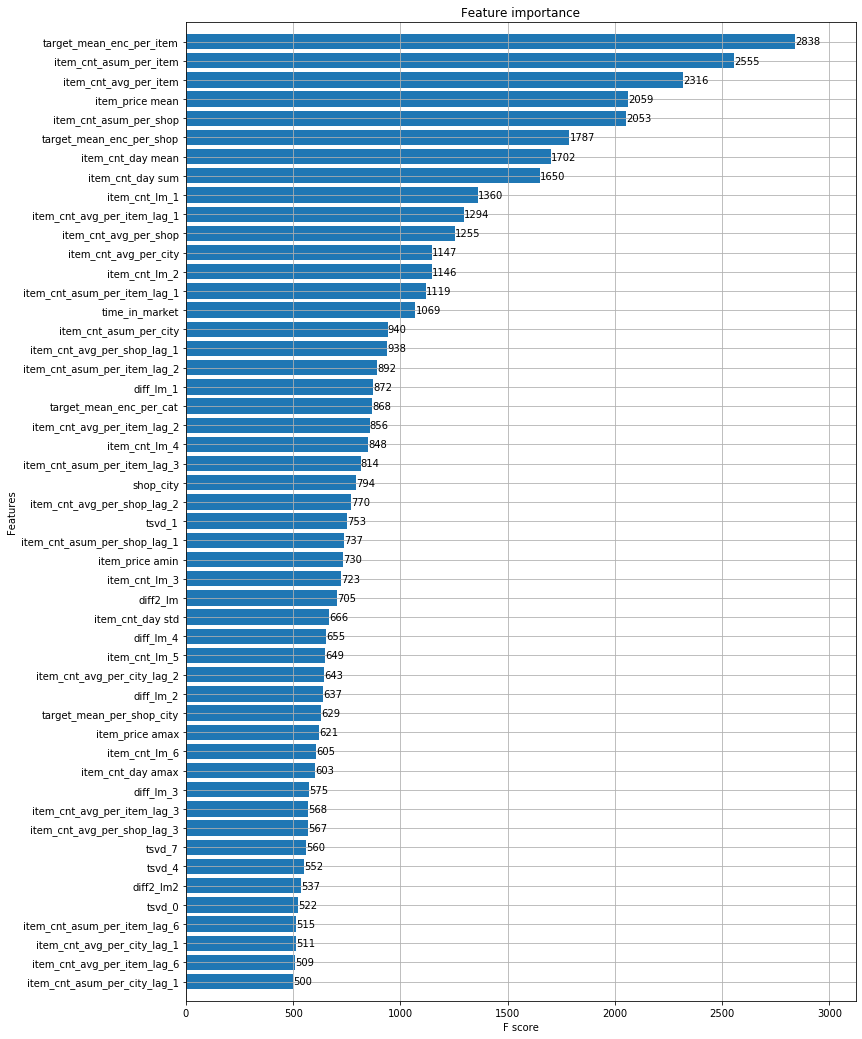

the RMSE of test: 0.64


In [99]:
import xgboost as xgb
xgb_model = xgb.train(params= {
                                       'max_depth': 11,
                                       'colsample_bytree': 0.7,
                                      'subsample': 1,
                                      'alpha':2,
                                      'eta' : 0.2/2,
                                      'tree_method': 'exact'},
                 dtrain=train_dmatrix,
                              evals = [(train_dmatrix, 'eval_train'),(test_dmatrix, 'eval_test')],
                             num_boost_round = 50 , early_stopping_rounds = 20)
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model,
                            max_num_features=50,
                            height=0.8, ax=ax)
plt.show()
print("the RMSE of test: {0:.2f}".format(mse(y_test, xgb_model.predict(test_dmatrix,
                                                                           ntree_limit=xgb_model.best_ntree_limit))**0.5))

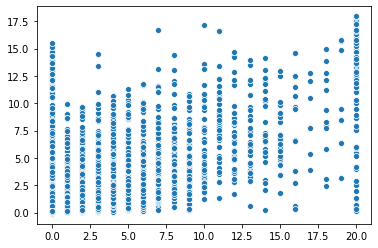

In [101]:
val_pred_xgb = xgb_model.predict(xgb.DMatrix(val.iloc[:,3:-1]), ntree_limit=xgb_model.best_ntree_limit)
sns.scatterplot(x = y_test, y = xgb_model.predict(test_dmatrix, ntree_limit=xgb_model.best_ntree_limit))

In [102]:
import lightgbm as lgb
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % mse(y_test, pred_lgb)**0.5)

Test R-squared for LightGBM is 0.654482


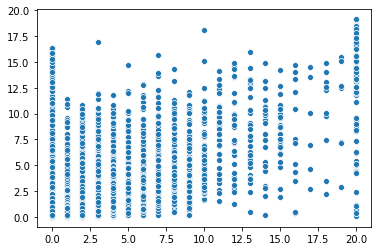

In [103]:
sns.scatterplot(x = y_test, y = pred_lgb)

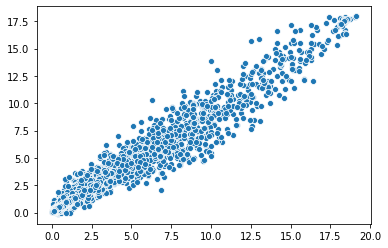

In [104]:
sns.scatterplot(x = pred_lgb, y = xgb_model.predict(test_dmatrix, ntree_limit=xgb_model.best_ntree_limit))

In [105]:
pred_xgb = xgb_model.predict(test_dmatrix, ntree_limit=xgb_model.best_ntree_limit)
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
rmse_scores = np.array([mse(y_test, np.dot(np.column_stack((pred_xgb, pred_lgb)), [alpha, 1 - alpha]))**0.5 for alpha in alphas_to_try])
best_alpha = alphas_to_try[rmse_scores.argmin()] # YOUR CODE GOES HERE
rmse_train_simple_mix = rmse_scores.min()

In [106]:
mse(y_test, best_alpha * pred_xgb + (1-best_alpha) * pred_lgb)**0.5

0.6381299452229799

In [ ]:
"""rf_grid = {
    'n_estimators': range(100,300, 50),
    'max_depth': range(6,12,1),
    'min_samples_split': [0.5,0.6,0.7]
}
rf = RandomForestRegressor()
model_cv = RandomizedSearchCV(
    estimator = rf, n_iter = 10,
    param_distributions = rf_grid, 
    cv = [(slice(None), slice(None))],
    verbose = 1, random_state = 42,n_jobs = -1,
    return_train_score = True
                             )
model_cv.fit(X_train, y_train)
print("the RMSE of test: {0:.2f}".format(mse(y_test, model_cv.best_estimator_.predict(X_test))**0.5))"""

Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [107]:
val_pred_lgb = model.predict(val.iloc[:,3:-1])

In [108]:
val['item_cnt_month'] = best_alpha * val_pred_xgb + (1-best_alpha) * val_pred_lgb #val_pred_lgb #val_pred_xgb

In [109]:
val_mean = np.mean(best_alpha * val_pred_xgb + (1-best_alpha) * val_pred_lgb)

In [119]:
submission = test.merge(val[['shop_id','item_id','item_cnt_month']], how = 'left')

In [120]:
submission['item_cnt_month'] = submission['item_cnt_month'].fillna(val_mean)
submission['item_cnt_month']  = submission['item_cnt_month'].clip(0,20)

In [121]:
#submission['item_cnt_month']  = submission['item_cnt_month'] - 0.02
submission.head()

ID  shop_id  item_id  item_cnt_month
0   0        5     5037        0.437034
1   1        5     5320        0.246228
2   2        5     5233        0.905768
3   3        5     5232        0.443808
4   4        5     5268        0.246228

In [136]:
submission[['ID','item_cnt_month']].to_csv('kaggle_submission.csv', sep = ',', index = False)

In [128]:
submission.item_cnt_month.min()

0.023715674877166748

In [129]:
submission.iloc[69]

ID                  69.000000
shop_id              5.000000
item_id           3686.000000
item_cnt_month       0.081503
Name: 69, dtype: float64